In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import curve_fit
import pandas as pd
import xlrd
import typing


In [2]:
def correlation(t, A, B):
    y = A*(np.exp(-2*B*t))
    return y


In [3]:
def relaxationrate(filename, filetype, Angle):
    
    if filetype == 'excel':
        data = pd.read_excel(filename)
    if filetype == 'csv':
        data = pd.read_csv(filename, encoding= 'unicode_escape')
    
    xlabel = data[data.columns[0]][0]
    ylabel = data[data.columns[1]][0]
    
    Time = data[data.columns[0]][1:201]
    Correlation = data[data.columns[1]][1:201]
    
    x=[]
    y=[]
    
    x = np.array(list(map(float, Time)))
    y = np.array(list(map(float, Correlation)))
    
    parameters, covariance = curve_fit(correlation, x, y, p0 = [0.1,0.1], bounds = (0, 10) )
    
    best_A = parameters[0]
    best_B = parameters[1]
    #print("A:", best_A)
    print("Relaxation Rate for",Angle,"deg", best_B, "1/microsec")
    
    if Angle == 60:
        Color = 'r'
        Figure = 2
    if Angle == 90:
        Color = 'b'
        Figure = 3
    if Angle == 120:
        Color = 'g'
        Figure = 4
    
    fit_y = correlation(x, best_A, best_B)
    plt.figure(Figure)
    plt.plot(x, y, 'o',markersize = 2, color = 'k')
    plt.plot(x, fit_y, '-', label = Angle, color = Color)
    plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(filename)
    plt.legend()
    #plt.savefig(filename,format='png') #saves over original file right now and kills it making it a png, don't uncomment for now
    
    return best_B


In [4]:
def scatteringvec(RefractiveIndex, Angle): 
    
    RI = RefractiveIndex #Refractive Index of the sample
    wavelength = 637 # Units - nm, comes from the wavelength of the laser used in the DLS
    radian = (Angle*np.pi)/180
    
    q = ( 4*np.pi*(RI)*(np.sin(radian/2)) )/(wavelength) #Units 1/nm
    
    print("Scattering Vector 'q' for",Angle, "deg:", q, "1/nm")
    
    return q


In [5]:
def diffusioncoef(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, RefractiveIndex):
    
    q2 = np.zeros(3)
    q2[0] = scatteringvec(RefractiveIndex, 60)**2 #Units 1/nm
    q2[1] = scatteringvec(RefractiveIndex, 90)**2 #Units 1/nm
    q2[2] = scatteringvec(RefractiveIndex, 120)**2 #Units 1/nm
    
    B = np.zeros(3)
    B[0] = relaxationrate(sixtydeg_filename, filetype, 60) #Units - 1/microsec
    B[1] = relaxationrate(nintydeg_filename, filetype, 90) #Units - 1/microsec
    B[2] = relaxationrate(onetwentydeg_filename, filetype, 120) #Units - 1/microsec
    
    m, b = np.polyfit(q2, B, 1)
    
    plt.figure(1)
    plt.scatter(q2, B)
    plt.plot(q2, m*(q2)+b)
    
    plt.xlabel("Square Scattering Vector 'q^2' ")
    plt.ylabel("Relaxation Rate")
    plt.title("Diffusion Coefficient")
    
    D = m
    
    print(" ")
    print("Diffusion Coefficient 'D':",D, "nm^2 / microsec")
    
    return D


In [6]:
def hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, RefractiveIndex, Viscosity):
    
    kB = 1.380649*(1e-16) #Units - g*cm^2 / K*s^2
    T = 298.15 #Units - Kelvin, room temperature which should be the temperature of the sample
    D = diffusioncoef(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, RefractiveIndex)*(1e-8) #Units - converting nm^2 / microsec to cm^2 / s
    
    Rh = (kB*T)/(6*np.pi*D*Viscosity)*(1e7) #Units - converting cm to nm (depends a lot on units of viscosity)
    
    print("Hydrodynamic Radius 'Rh':", Rh, "nm")
    
    return Rh


Scattering Vector 'q' for 60 deg: 0.014756114944333844 1/nm
Scattering Vector 'q' for 90 deg: 0.020868297882213237 1/nm
Scattering Vector 'q' for 120 deg: 0.02555834080591262 1/nm
Relaxation Rate for 60 deg 0.8819120408230136 1/microsec
Relaxation Rate for 90 deg 1.4496299535374189 1/microsec
Relaxation Rate for 120 deg 1.7837269170324057 1/microsec
 
Diffusion Coefficient 'D': 2070.8247185239316 nm^2 / microsec
Hydrodynamic Radius 'Rh': 0.19035481566609289 nm


0.19035481566609289

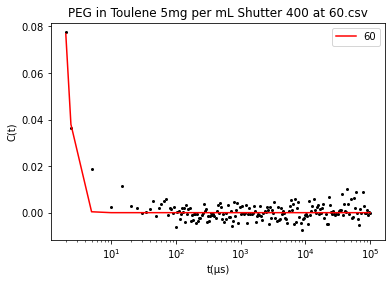

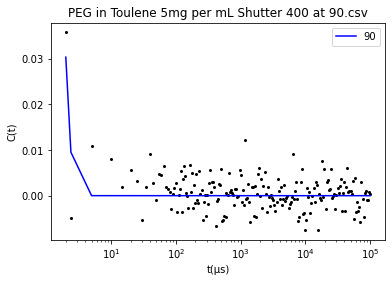

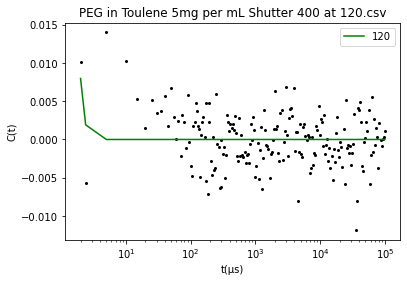

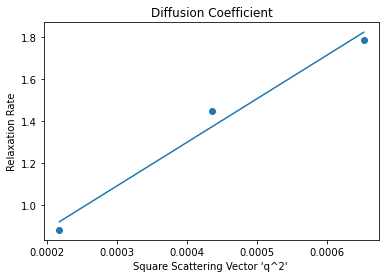

In [8]:
hydrorad(
    
    sixtydeg_filename = 'PEG in Toulene 5mg per mL Shutter 400 at 60.csv' ,
    
    nintydeg_filename = 'PEG in Toulene 5mg per mL Shutter 400 at 90.csv' ,
    
    onetwentydeg_filename = 'PEG in Toulene 5mg per mL Shutter 400 at 120.csv' ,
         
    filetype = 'csv' ,
    #either 'excel' or 'csv'
         
    RefractiveIndex = 1.496 ,
    
    Viscosity = 0.00554
    #Viscosity in units g /cm*s (for all intents and purposes 100 mPa*s = 1 g /cm*s)
         
        )
